# 2states Hidden Markov Model with Gaussian Emissions Categorical sampling in pymc3

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.15.4
Running on theano: v1.0.4
Running on PYMC3: v3.6


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
%pylab inline

plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/jhub/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
cwd = os.getcwd()
cwd

'/home/meysam/Hidden-Markov-Models'

The transition matrix used to generate it:

[[0.9, 0.1], 
 [0.3, 0.7]]


In [9]:
data_states = np.loadtxt('SimulatedN2states.txt')
measurement= np.loadtxt('SimulatedMeasurementN2states.txt')

In [10]:
data_states.shape, measurement.shape

((1000,), (1000,))

In [11]:
Nt=len(measurement)

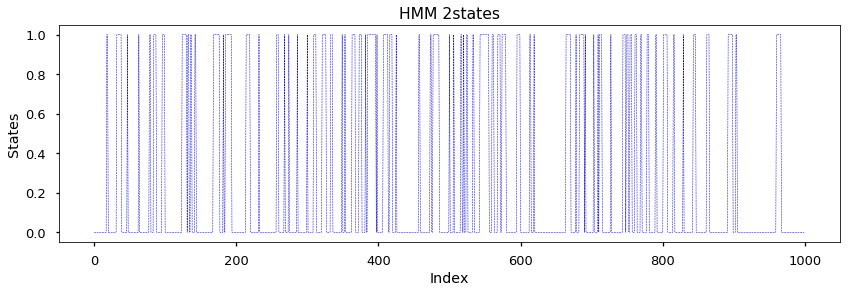

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(data_states, '--', color='mediumblue', linewidth=.5)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","Datastates_N2states.png"))
plt.show()

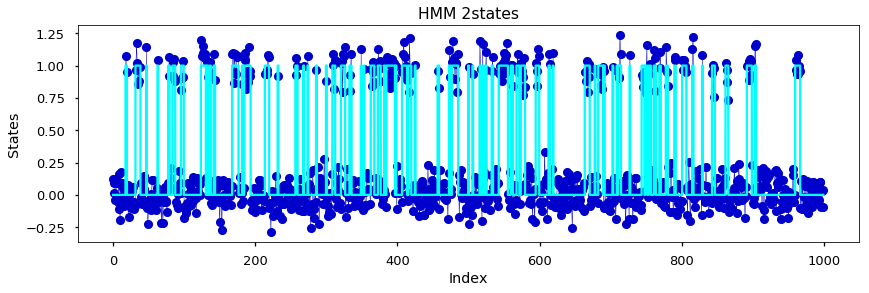

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:Nt], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:Nt], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states.png"))
plt.show()

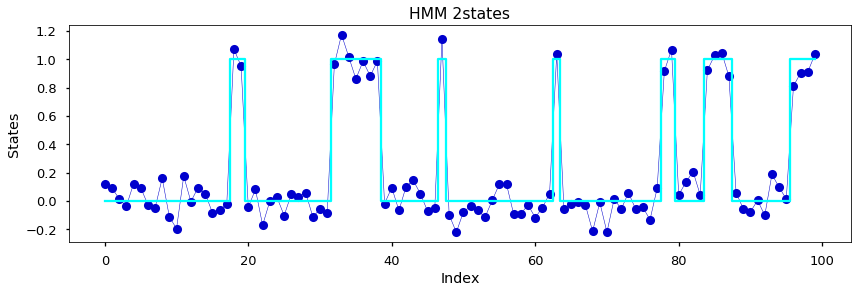

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:100], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:100], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states_zoom.png"))
plt.show()

In [15]:

class HMM2States(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

        
    def logp(self, x): 
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        PT = tt.stack((P1,P2))          
        PS = PT[x[:-1]]     
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(PS, shape=(Nt-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [16]:

class HMMGaussianEmissions_2states(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,Nt)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,Nt)
    
    states : tensor
         equilibrium probabilities
         shape = (Nt)
    
    """

    def __init__(self, A1=None, A2=None, S1=None, S2=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissions_2states, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.S1 = S1
        self.A2 = A2
        self.S2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        S1 = self.S1
        A2 = self.A2
        S2 = self.S2
        states = self.states
        

        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [17]:
# Two state model for simplicity.
N_states = 2

In [19]:
# Transition probability stochastic
theta = np.ones(N_states) + 1.

In [20]:
theta

array([2., 2.])

In [21]:
# Prior

alphaA = 2.1
betaA = 1.1
alphaS = 2.1
betaS = 1.0

### Nuts and BinaryGibbsMetropolis

In [23]:
basic_model = pm.Model()

with basic_model:

    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    A1 = pm.Normal('A1',mu=0, sd=1)
    A2 = pm.Normal('A2',mu=1, sd=1)
    
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMM2States('states',PA,P1,P2, shape=Nt)
    
    emission = HMMGaussianEmissions_2states('emission',
                                    A1=A1,
                                    A2=A2,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = measurement)
    

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [24]:
from pymc3.backends import SQLite , Text

In [25]:
NUTS_KWARGS={'tarhet_accept':0.99, 'max_treedepth': 10.}

In [30]:
with basic_model:
    db=pm.backends.Text('trace_nuts')
    trace_nuts = pm.sample(draws=2000, tune=10000, nuts_kwarg=NUTS_KWARGS, trace_nuts=db, chains=4)

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [S2, S1, A2, A1, P2, P1]
>BinaryGibbsMetropolis: [states]
Sampling 4 chains: 100%|██████████| 48000/48000 [44:12<00:00,  4.60draws/s]


In [31]:
filename='data_output_HMM2states_InferringEmission_Nuts'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

Directory Exists


In [32]:
directory_nuts=os.path.join(cwd, str(filename))
directory_nuts

'/home/meysam/Hidden-Markov-Models/data_output_HMM2states_InferringEmission_Nuts'

In [33]:
pm.backends.text.dump(directory_nuts, trace_nuts, chains=None)

In [34]:
with basic_model:
     trace_nuts=pm.backends.text.load(directory_nuts)

In [35]:
print(trace_nuts.varnames)

['P1_stickbreaking__', 'P2_stickbreaking__', 'A1', 'A2', 'S1_log__', 'S2_log__', 'states', 'P1', 'P2', 'S1', 'S2', 'PA']


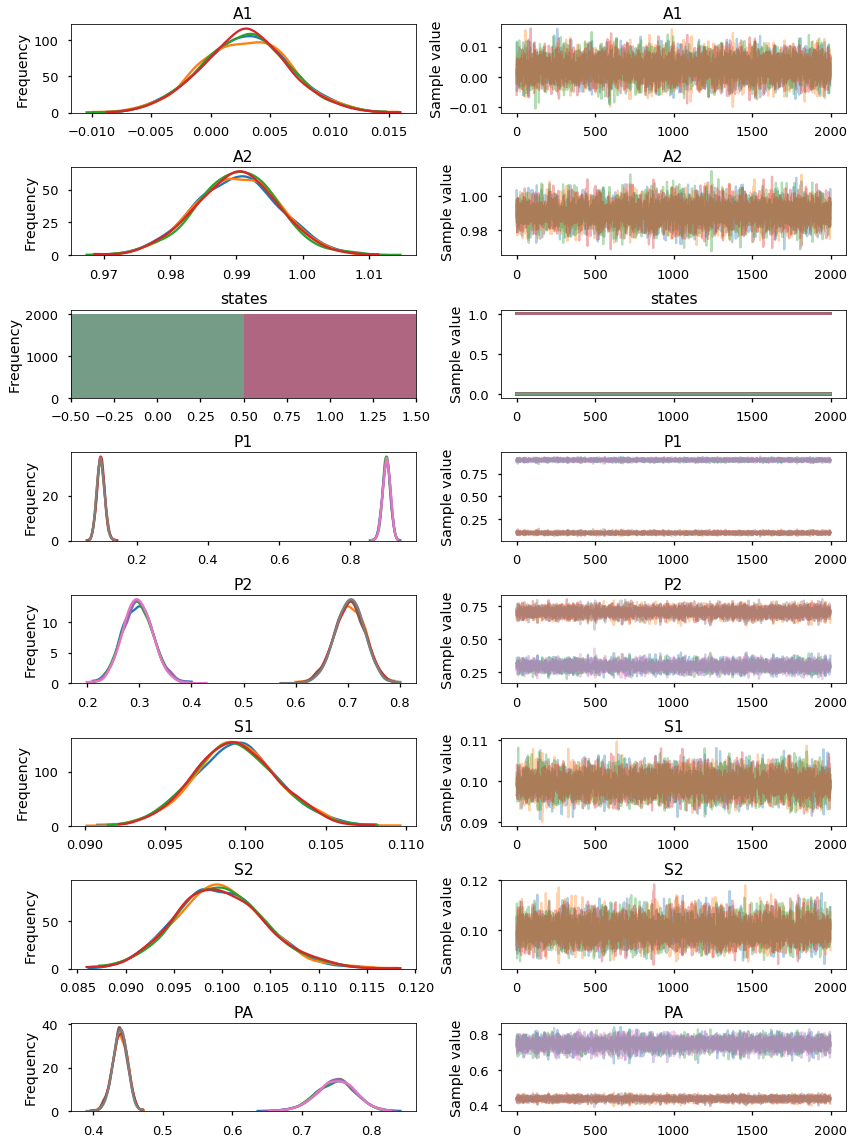

In [36]:
pm.traceplot(trace_nuts)
plt.savefig(os.path.join(cwd+"/Figs","EstimatedParams_HMM2states_InferringEmission_Nuts.png"))
plt.show()

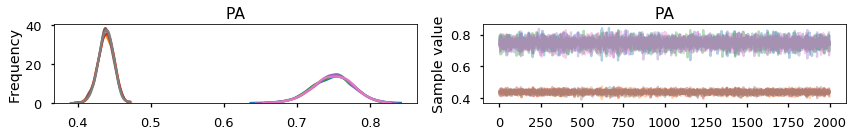

In [37]:
pm.traceplot(trace_nuts, varnames=['PA']);

/home/meysam/.local/lib/python3.7/site-packages/pymc3/plots/pairplot.py:148: UserWarning: No divergences were found.
  warnings.warn('No divergences were found.')


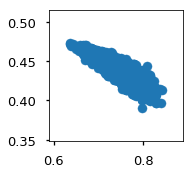

In [38]:
pm.pairplot(trace_nuts, varnames=['PA', 'P1', 'P2'], divergences=True);

In [39]:
trace_nuts['states'].shape

(8000, 1000)

In [40]:
A1_est=np.asarray(trace_nuts.get_values('A1', burn=0, combine=True))
A2_est=np.asarray(trace_nuts.get_values('A2', burn=0, combine=True))
P1_est=np.asarray(trace_nuts.get_values('P1', burn=0, combine=True))
P2_est=np.asarray(trace_nuts.get_values('P2', burn=0, combine=True))
S1_est=np.asarray(trace_nuts.get_values('S1', burn=0, combine=True))
S2_est=np.asarray(trace_nuts.get_values('S2', burn=0, combine=True))
PA_est=np.asarray(trace_nuts.get_values('PA', burn=0, combine=True))

In [41]:
A1_est.shape

(8000,)

In [42]:
A1_mean=np.mean(A1_est, axis=0)
A2_mean=np.mean(A2_est, axis=0)
P1_mean=np.mean(P1_est, axis=0)
P2_mean=np.mean(P2_est, axis=0)
S1_mean=np.mean(S1_est, axis=0)
S2_mean=np.mean(S2_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [43]:
A1_mean,  A2_mean , P1_mean, P2_mean, S1_mean, S2_mean, PA_mean

(0.0028536509486661557,
 0.9900082681585758,
 array([0.90071018, 0.09928982]),
 array([0.2967202, 0.7032798]),
 0.09936174595522873,
 0.09975661421222264,
 array([0.74846332, 0.43829169]))

In [44]:
P_mean=np.stack((P1_mean, P2_mean))

In [45]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [46]:
sum(np.sqrt((P_th-P_mean)**2))

0.007979950656489931

In [47]:
sample_avg=np.average(trace_nuts['states'][0:],axis=0)

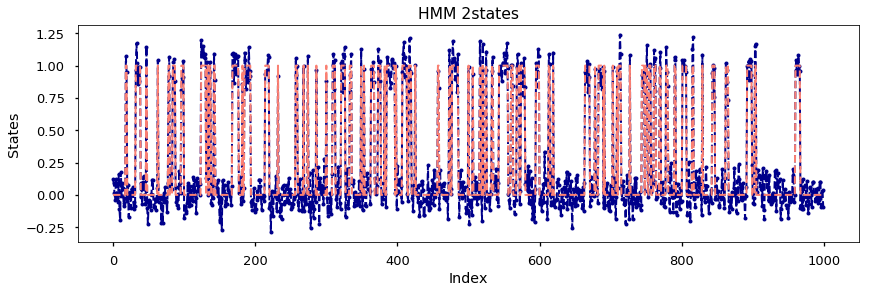

In [48]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.plot(sample_avg, color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringEmission_Nuts.png"))
plt.show()

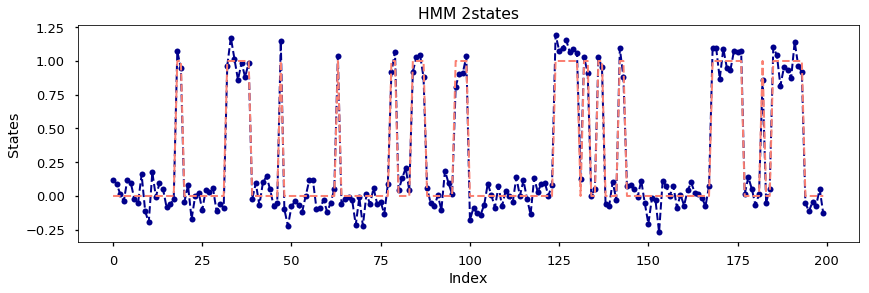

In [49]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6)
plt.plot(sample_avg[0:200], color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringEmission_Nuts_zoom.png"))
plt.show()

In [50]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_nuts, samples=200, model=basic_model)

100%|██████████| 200/200 [00:11<00:00, 17.19it/s]


In [51]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

emission => [[ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 ...
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]]
(200, 1000)


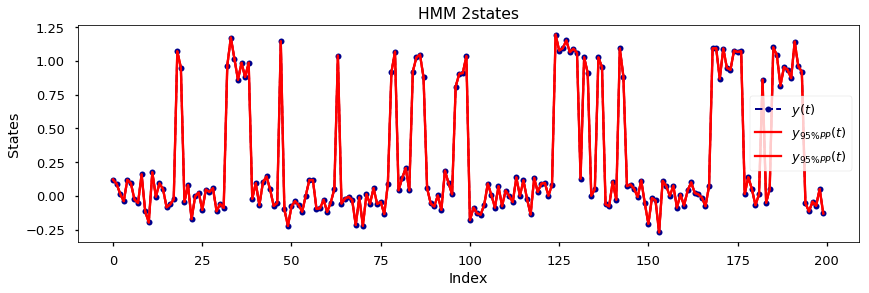

In [52]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringEmission_Nuts.png"))
plt.show()

In [53]:
trace_nuts.stat_names

set()

In [54]:
summary_nuts=pm.summary(trace_nuts).round(2)

In [55]:
summary_nuts[summary_nuts['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat


In [54]:
#trace_nuts_df = pm.trace_to_dataframe(trace_nuts)
#print(trace_nuts_df.describe().drop('count').T)

In [49]:
#from pandas.plotting import scatter_matrix
#scatter_matrix(trace_nuts_df, figsize=(12,12));

### Metropolis and CategoricalGibbsMetropolis

In [ ]:
basic_model2 = pm.Model()

with basic_model2:
  
    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    A1 = pm.Normal('A1',mu=0, sd=1)
    A2 = pm.Normal('A2',mu=1, sd=1)
    
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMM2States('states',PA,P1,P2, shape=Nt)
    
    emission = HMMGaussianEmissions_2states('emission',
                                    A1=A1,
                                    A2=A2,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = measurement)
    
    step1 = pm.Metropolis(vars=[P1, P2, A1, A2, S1, S2, PA, emission])
    step2 = pm.CategoricalGibbsMetropolis(vars=[states])

In [57]:
with basic_model2:
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    db_categorical=pm.backends.Text('trace_categorical')
    trace_categorical = pm.sample(draws=2000, tune=10000, step=[step1, step2],  start=start,  trace_categorical=db_categorical, chains=4)

Sampling 4 chains:  17%|█▋        | 8227/48000 [09:42<47:58, 13.82draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains:  53%|█████▎    | 25648/48000 [30:31<26:26, 14.09draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains: 100%|█████████▉| 47782/48000 [59:09<01:14,  2.93draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing

In [58]:
filename='data_output_HMM2states_InferringEmission_Categorical'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

In [59]:
directory_categorical=os.path.join(cwd, str(filename))
directory_categorical

'/home/meysam/Hidden-Markov-Models/data_output_HMM2states_InferringEmission_Categorical'

In [60]:
pm.backends.text.dump(directory_categorical, trace_categorical, chains=None)

In [61]:
with basic_model2:
     trace_categorical=pm.backends.text.load(directory_categorical)

In [62]:
print(trace_categorical.varnames)

['P1_stickbreaking__', 'P2_stickbreaking__', 'A1', 'A2', 'S1_log__', 'S2_log__', 'states', 'P1', 'P2', 'S1', 'S2', 'PA']


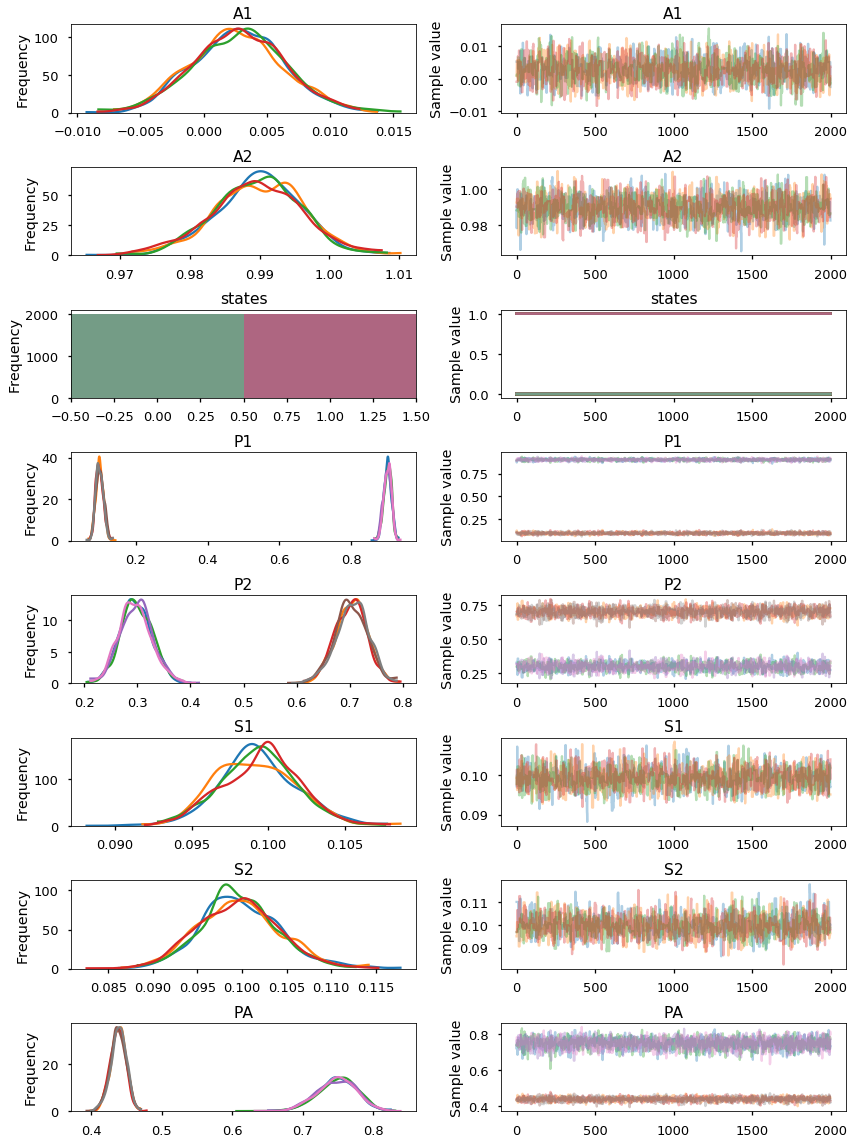

In [63]:
pm.traceplot(trace_categorical)
plt.savefig(os.path.join(cwd+"/Figs","EstimatedParams_HMM2states_InferringEmission_Categorical.png"))
plt.show()

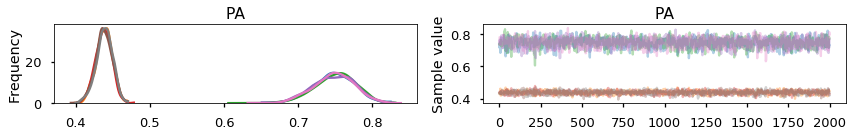

In [64]:
pm.traceplot(trace_categorical, varnames=['PA']);

/home/meysam/.local/lib/python3.7/site-packages/pymc3/plots/pairplot.py:148: UserWarning: No divergences were found.
  warnings.warn('No divergences were found.')


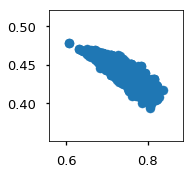

In [65]:
pm.pairplot(trace_categorical, varnames=['PA', 'P1', 'P2'], divergences=True);

In [66]:
trace_categorical['states'].shape

(8000, 1000)

In [67]:
A1_est=np.asarray(trace_categorical.get_values('A1', burn=0, combine=True))
A2_est=np.asarray(trace_categorical.get_values('A2', burn=0, combine=True))
P1_est=np.asarray(trace_categorical.get_values('P1', burn=0, combine=True))
P2_est=np.asarray(trace_categorical.get_values('P2', burn=0, combine=True))
S1_est=np.asarray(trace_categorical.get_values('S1', burn=0, combine=True))
S2_est=np.asarray(trace_categorical.get_values('S2', burn=0, combine=True))
PA_est=np.asarray(trace_categorical.get_values('PA', burn=0, combine=True))

In [68]:
A1_est.shape

(8000,)

In [69]:
A1_mean=np.mean(A1_est, axis=0)
A2_mean=np.mean(A2_est, axis=0)
P1_mean=np.mean(P1_est, axis=0)
P2_mean=np.mean(P2_est, axis=0)
S1_mean=np.mean(S1_est, axis=0)
S2_mean=np.mean(S2_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [70]:
A1_mean,  A2_mean , P1_mean, P2_mean, S1_mean, S2_mean, PA_mean

(0.002722178821312452,
 0.9897520190242519,
 array([0.90032915, 0.09967085]),
 array([0.29727566, 0.70272434]),
 0.09933651813806522,
 0.09964166120841551,
 array([0.74801046, 0.43819193]))

In [71]:
P_mean=np.stack((P1_mean, P2_mean))

In [72]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [73]:
sum(np.sqrt((P_th-P_mean)**2))

0.00610697729921926

In [74]:
sample_avg=np.average(trace_categorical['states'][0:],axis=0)

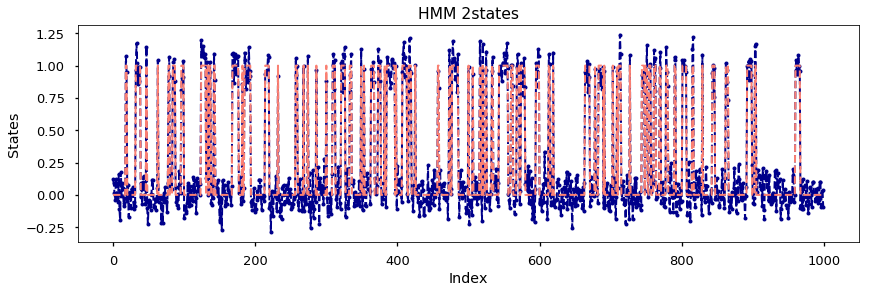

In [75]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.plot(sample_avg, color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringEmission_Categorical.png"))
plt.show()

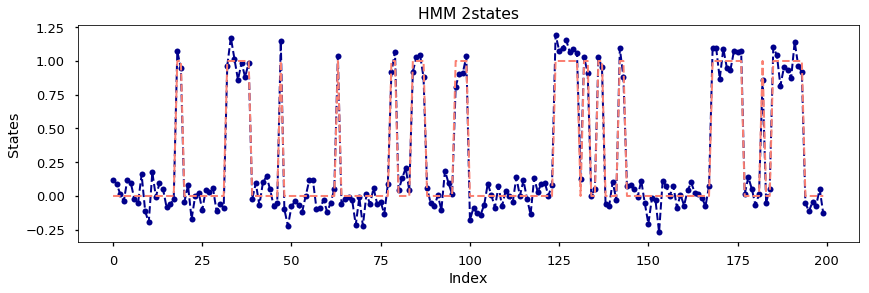

In [76]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6)
plt.plot(sample_avg[0:200], color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringEmission_Categorical_zoom.png"))
plt.show()

In [77]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_categorical, samples=200, model=basic_model2)

100%|██████████| 200/200 [00:12<00:00, 17.83it/s]


In [78]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

emission => [[ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 ...
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]
 [ 0.12113637  0.08952768  0.01541167 ...  0.03150619  0.03453782
  -0.09323931]]
(200, 1000)


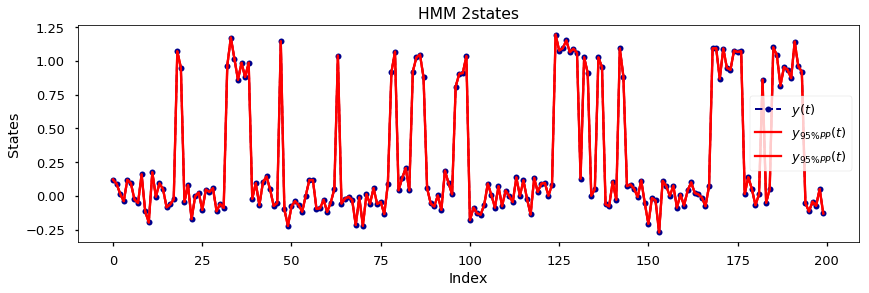

In [79]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringEmission_Categorical.png"))
plt.show()

In [80]:
trace_categorical.stat_names

set()

In [81]:
summary_categorical=pm.summary(trace_categorical).round(2)

In [82]:
summary_categorical[summary_categorical['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
